# EDA and Cleaning

Prior to building our recommender system, we cleaned and combined our `books` and `book_ratings` tables. The `users` table was not used as user location and age are not pertinent to our item-to-item recommender. There was a discrepancy between the books in our `books` table and those in `book_ratings`. The dataframes were combined and books that were not available in both were removed prior to any cleaning or visualization. Book count, publication years, and ratings count were explored to get a better understanding of our data. Special attention was given to explicit and implicit ratings, given that it is the feature that will be used for our recommender.

New dataframes were created and loaded onto the server. SQL file used to create these tables can be found [here](http://localhost:8888/lab/tree/dsi%2FProjects%2Fcapstone%2Fsql_files%2F02_eda_create_tables.sql)

## Contents
-  [Retrieve Data from PostgreSQL Database](#Retrieve-Data-from-PostgreSQL-Database)
-  [Combine books and ratings](#Combine-books-and-ratings)
-  [Duplicated book title and book author](#Duplicated-book-title-and-book-author)
-  [Clean Data](#Clean-Data)
-  [Explicit and Implicit Ratings](#Explicit-and-Implicit-Ratings)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import psycopg2 as pg2
from sqlalchemy import create_engine

sns.set_style('darkgrid')
sns.set_palette(palette='colorblind')
%matplotlib inline

In [2]:
%run ../bx_sql.py

We create an engine to establish a relationship between our machine and the database living on AWS. This will allow us to query our tables.

In [3]:
engine = create_engine(f'postgres://{USER}:{PASSWORD}@{FULL_IP_ADDRESS}:5432/{DBNAME}')

## Retrieve Data from PostgreSQL Database

The Book-Crossing dataset comprises of 3 tables: Users, Books and Book-Ratings. A table with the same name was created for each in the `postgres` database. We will retrieve the entire `books` and `book_ratings` tables and save them as dataframes.

### Books

In [4]:
books_df = pd.read_sql_table('books', engine)

books_df.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
0,0373810261,Miss Liz'S Passion (Men At Work) (Men at Work ...,Sherryl Woods,1998,Harlequin,http://images.amazon.com/images/P/0373810261.0...,http://images.amazon.com/images/P/0373810261.0...,http://images.amazon.com/images/P/0373810261.0...
1,843485676X,Gran Angular - Alerta Roja: Un Frio Viento Del...,C Puerto,0,Ediciones SM,http://images.amazon.com/images/P/843485676X.0...,http://images.amazon.com/images/P/843485676X.0...,http://images.amazon.com/images/P/843485676X.0...
2,1880684497,Prospero's Mirror: A Translators' Portfolio of...,Ilan Stavans,1998,Curbstone Press,http://images.amazon.com/images/P/1880684497.0...,http://images.amazon.com/images/P/1880684497.0...,http://images.amazon.com/images/P/1880684497.0...
3,0679421041,River in the Desert: Modern Travels in Ancient...,Paul William Roberts,1993,Random House,http://images.amazon.com/images/P/0679421041.0...,http://images.amazon.com/images/P/0679421041.0...,http://images.amazon.com/images/P/0679421041.0...
4,0821721828,Moontide Embrace,Constance O'Banyon,1987,Zebra Books,http://images.amazon.com/images/P/0821721828.0...,http://images.amazon.com/images/P/0821721828.0...,http://images.amazon.com/images/P/0821721828.0...


Image urls are unnecessary. These are removed before we move forward.

In [5]:
books_df.drop(columns=['image_url_l', 'image_url_m', 'image_url_s'], inplace=True)

### Ratings

In [6]:
ratings_df = pd.read_sql_table('book_ratings', engine)

ratings_df.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## Combine `books` and `ratings`

Prior to data cleaning, we need to check if books in `ratings_df` are in `books_df`. If we do not have any additional metadata besides `isbn` for books with ratings, we will not be able to easily provide recommendations with book titles.

In [7]:
print('Ratings ISBN:',ratings_df['isbn'].nunique())
print('Books ISBN:  ',books_df['isbn'].nunique())
ratings_df['isbn'].nunique() == books_df['isbn'].nunique()

Ratings ISBN: 340556
Books ISBN:   271379


False

We have ratings for books in `ratings_df` that do not exist in`books_df`. We only want to keep books that exist in both dataframes and save it to `match_isbns`.

In [8]:
match_isbns = ratings_df[ratings_df['isbn'].isin(books_df['isbn'])]

In [9]:
print('Number of Ratings:',match_isbns.shape[0])
print('Number of Books:  ',match_isbns['isbn'].nunique())

Number of Ratings: 1031175
Number of Books:   270170


Now we're left with 270,170 books and 1,031,175 ratings.

We're going to merge `match_isbns` with `books_df` in order to have all information in one dataframe (`combined_df`).

In [10]:
combined_df = match_isbns.merge(books_df[['isbn', 'book_author', 'book_title']], how='left')

In [11]:
combined_df.head()

,user_id,isbn,book_rating,book_author,book_title
0,276725,034545104X,0,M. J. Rose,Flesh Tones: A Novel
1,276726,0155061224,5,Judith Rae,Rites of Passage
2,276727,0446520802,0,Nicholas Sparks,The Notebook
3,276729,052165615X,3,Philip Prowse,Help!: Level 1
4,276729,0521795028,6,Sue Leather,The Amsterdam Connection : Level 4 (Cambridge ...


## Duplicated `book_title` and `book_author`

Book editions are not influential when providing recommendations. We're going to assign one isbn to books that share the same title and author to ensure all ratings for a given book is considered.

In [12]:
len(books_df[books_df[['book_title', 'book_author']].duplicated()])

20175

We have 20,175 books that share the same title and author with different isbns.

We remove these duplicates and save it as `unique_books`.

In [13]:
unique_books = books_df.drop_duplicates(subset=['book_author','book_title'])

In order to assign one isbn for different book editions, we merge `unique_books` with `combined_df`. This is saved to `ratings_and_books`. 

In [14]:
ratings_and_books = unique_books.merge(combined_df.drop(columns=['isbn']), 
                                       on=['book_author', 'book_title'])

Check to see if we retained all of our ratings. 

In [15]:
ratings_and_books.shape[0] == combined_df.shape[0]

True

In [16]:
print('Users:  ', ratings_and_books['user_id'].nunique())
print('Books:  ', ratings_and_books['isbn'].nunique())
print('Ratings:', ratings_and_books.shape[0])

Users:   92107
Books:   250105
Ratings: 1031175


### Save as CSV for PostgreSQL Database

Save `ratings_and_books` as a csv to put into postgres.

In [17]:
ratings_and_books.to_csv('../data/ratings_and_books.csv', index=False)

## Clean Data

In [18]:
ratings_and_books.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
0,0373810261,Miss Liz'S Passion (Men At Work) (Men at Work ...,Sherryl Woods,1998,Harlequin,129358,0
1,843485676X,Gran Angular - Alerta Roja: Un Frio Viento Del...,C Puerto,0,Ediciones SM,184386,7
2,1880684497,Prospero's Mirror: A Translators' Portfolio of...,Ilan Stavans,1998,Curbstone Press,81492,0
3,0679421041,River in the Desert: Modern Travels in Ancient...,Paul William Roberts,1993,Random House,105374,0
4,0821721828,Moontide Embrace,Constance O'Banyon,1987,Zebra Books,114368,5


In [19]:
ratings_and_books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031175 entries, 0 to 1031174
Data columns (total 7 columns):
isbn                   1031175 non-null object
book_title             1031175 non-null object
book_author            1031174 non-null object
year_of_publication    1031175 non-null int64
publisher              1031173 non-null object
user_id                1031175 non-null int64
book_rating            1031175 non-null int64
dtypes: int64(3), object(4)
memory usage: 62.9+ MB


In [20]:
ratings_and_books.isna().sum()

isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
user_id                0
book_rating            0
dtype: int64

### Title

Due to having books in different languages, non-english titles contain abnormal characters. The encoding was set to `latin-1` in order to be able to copy the csv files into postgres. Given that the title format varies per book and we do not want to remove characters that are displaying correctly, we will not be doing a robust cleaning for this column. 

We will be only removing HTML code artifact `&amp;` as that is seen in a number of book titles.

In [21]:
ratings_and_books['book_title'] = ratings_and_books['book_title'].apply(lambda x: re.sub('&amp;', '&', x))

### Author

The `author` column has one null value. We impute the missing value based on our source.

In [22]:
ratings_and_books[ratings_and_books['book_author'].isna()]

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
57789,9627982032,The Credit Suisse Guide to Managing Your Perso...,None,1995,Edinburgh Financial Publishing,98647,8


**Source**: [Amazon (The Credit Suisse Guide to Managing Your Personal Wealth)](https://www.amazon.ca/Credit-Suisse-Managing-Personal-Wealth/dp/9627982075)

In [23]:
ratings_and_books.loc[937250, ['book_author']] = 'Larissa Anne Downes'

In [24]:
ratings_and_books['book_author'].nunique()

101594

Of the 250,105 books, we have 101,594 unique authors.

### Publisher

The `publisher` column has two null values. We impute the missing value based on our sources.

In [25]:
ratings_and_books[ratings_and_books['publisher'].isna()]

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
965330,193169656X,Tyrant Moon,Elaine Corvidae,2002,None,98391,9
965588,1931696993,Finders Keepers,Linnea Sinclair,2001,None,98391,9


**Sources:**
-  [AbeBooks (Tyrant Moon)](https://www.abebooks.com/9781931696562/Tyrant-Moon-Elaine-Corvidae-193169656X/plp)
-  [Google Books (Finders Keepers)](https://books.google.com/books/about/Finders_Keepers.html?id=M9pbPgAACAAJ)

In [26]:
ratings_and_books.loc[839945, ['publisher']] = 'Novelbooks Incorporated'

In [27]:
ratings_and_books.loc[840232, ['publisher']] = 'Novelbooks Incorporated'

### Year of Publication

In [28]:
np.asarray(sorted(ratings_and_books['year_of_publication'].unique()))

array([   0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908,
       1909, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2008, 2011, 2012, 2020, 2021, 2024, 2026,
       2030, 2037, 2038, 2050])

We can see that there are publication years that are not viable. Since the dataset was collected in 2004, all years after that are incorrect. Having a publication year of `0` is impossible.

In [29]:
ratings_and_books[(ratings_and_books['year_of_publication'] == 0) | 
                  (ratings_and_books['year_of_publication'] > 2004)].shape[0]

16268

There are a total of 14,570 books that have incorrect publishing years.

In [30]:
np.asarray(sorted(ratings_and_books['year_of_publication'][
                    (ratings_and_books['year_of_publication'] > 0) & 
                    (ratings_and_books['year_of_publication'] < 2005)].value_counts().index))

array([1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909,
       1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004])

Incorrect publication years won't affect our recommendations, so we will leave them as is. However, they will be excluded for visualization purposes. We will plot the count of books each year to see the type of books that are included in our dataset.

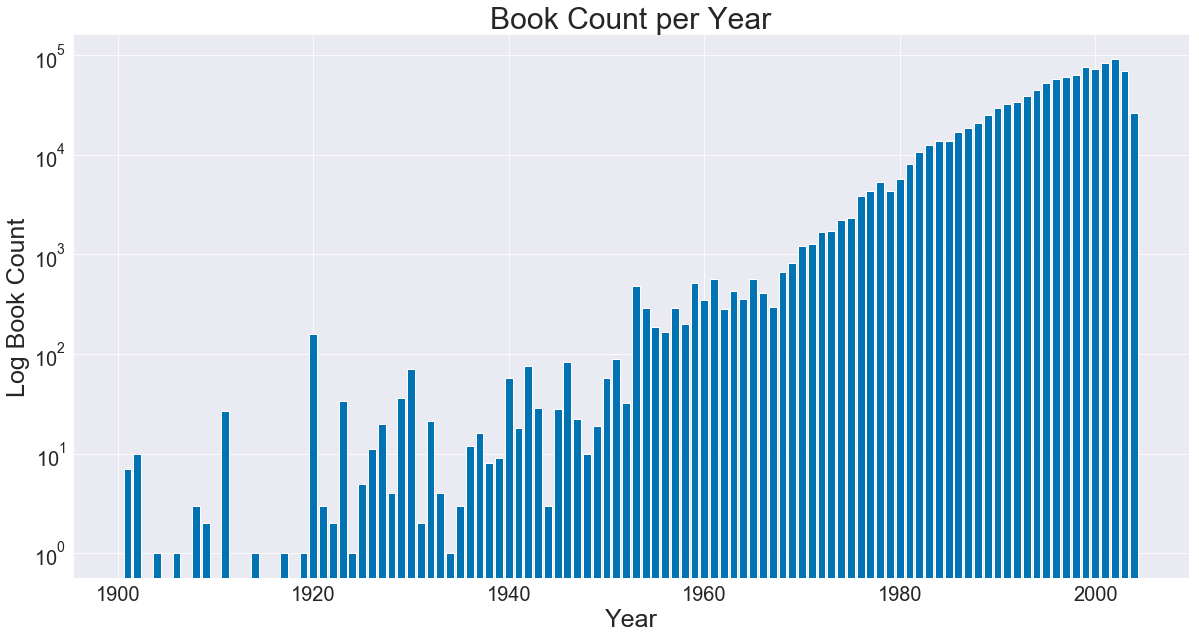

In [31]:
plt.figure(figsize=(20, 10))
plt.bar(x=ratings_and_books['year_of_publication'][
                    (ratings_and_books['year_of_publication'] > 1900) & 
                    (ratings_and_books['year_of_publication'] < 2005)].value_counts().index,
        height=ratings_and_books['year_of_publication'][
                    (ratings_and_books['year_of_publication'] > 1900) & 
                    (ratings_and_books['year_of_publication'] < 2005)].value_counts().values,
        log=True)
plt.title('Book Count per Year', fontsize=30)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Log Book Count', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  There's an exponential growth in book count as we move forward in time.
-  Most books were published in the 2000s.

### ISBN

ISBNs either have 13 digits, 10 digits, or 10 digits with an X. We'll use regex to check whether all our ISBNs are valid. ISBNs in the correct format are saved as `good_isbns`. We will then replace invalid ISBNs with an ISBN in the `books_df`, given the same book title and author (different edition). For books that only have one edition, the index is aved to `no_replacement_isbns`.  

In [32]:
good_isbns = ratings_and_books['isbn'].map(lambda x: x if re.findall('^[\dXx]+$', x) else None)

In [33]:
no_replacement_isbns = []
for i in good_isbns[good_isbns.isna()].index:
    bad_isbn = ratings_and_books.loc[i, 'isbn']
    title_author = books_df[books_df['isbn'] == bad_isbn][['book_title', 'book_author']].values[0]
    try:
        new_isbn = books_df[(books_df['book_title'] == title_author[0]) & 
                            (books_df['book_author'] == title_author[1]) & 
                            (books_df['isbn'] != bad_isbn)]['isbn'].values[0]
        ratings_and_books.loc[i, 'isbn'] = new_isbn
    except:
        no_replacement_isbns.append(i)

In [34]:
len(no_replacement_isbns)

65

In [35]:
ratings_and_books.loc[no_replacement_isbns[:5]]

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
8475,3518365479<90,"Suhrkamp TaschenbÃ?Â¼cher, Nr.47, Frost",Thomas Bernhard,1972,Suhrkamp,106173,0
32110,B00019U4II,"Big Four, The",Agatha Christie,0,PerfectBound,163140,8
36975,B0002K6K8O,The Underground City,Jules Verne,0,Digireads.com,179791,0
36977,B0002JV9PY,The Blockade Runners,Jules Verne,0,Digireads.com,179791,0
36990,B000051XGM,Off on a Comet,Jules Verne,0,Amazon Press,179791,0


There are 65 books with invalid ISBNs and no replacement. They're all 10 characters/digits in length and start with `B`. According to [Barcode Graphics](https://www.barcode.graphics/amazon-product-id/), they are Amazon Standard Identification Numbers (ASIN). Given that users will be searching by book title, this is not a big issue. It will be difficult, however, to find the book's product page given an ISBN for next steps.

### Users

We will look at user's behavior in regards to the number of ratings an individual typically gives.

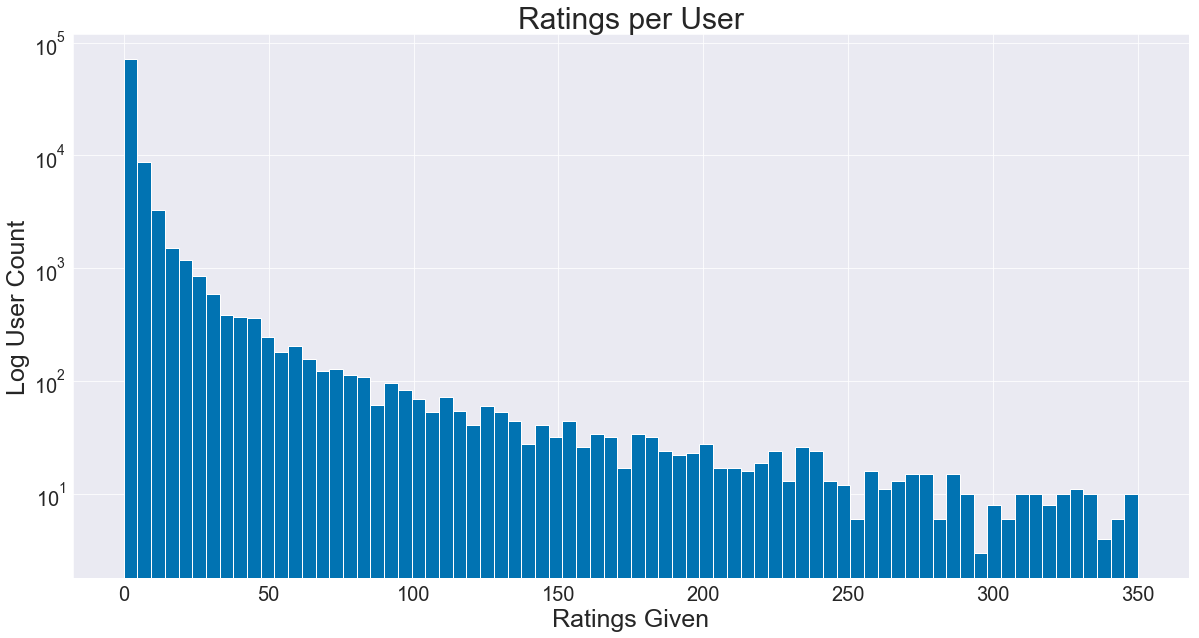

In [36]:
plt.figure(figsize=(20, 10))
plt.hist(x=ratings_and_books['user_id'].value_counts().values,
         bins=np.linspace(0, 350, 75)) 
plt.gca().set_yscale("log")
plt.title('Ratings per User', fontsize=30)
plt.xlabel('Ratings Given', fontsize=25)
plt.ylabel('Log User Count', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  The ratings given per user is heavily right skewed
-  Decreases exponentially
-  Even though more ratings than `350` were given, the user count for these values were mostly ones. 

### Ratings

The dataset comprised of implicit (`0`) and explicit (`1-10`) ratings. Implicit ratings indicate that users have interacted with the book, but did not rate it. We'll look at the book count for each given rating to get a better sense of our data.

In [37]:
ratings_and_books['book_rating'].value_counts().sort_index()

0     647323
1       1481
2       2375
3       5118
4       7617
5      45355
6      31689
7      66404
8      91806
9      60780
10     71227
Name: book_rating, dtype: int64

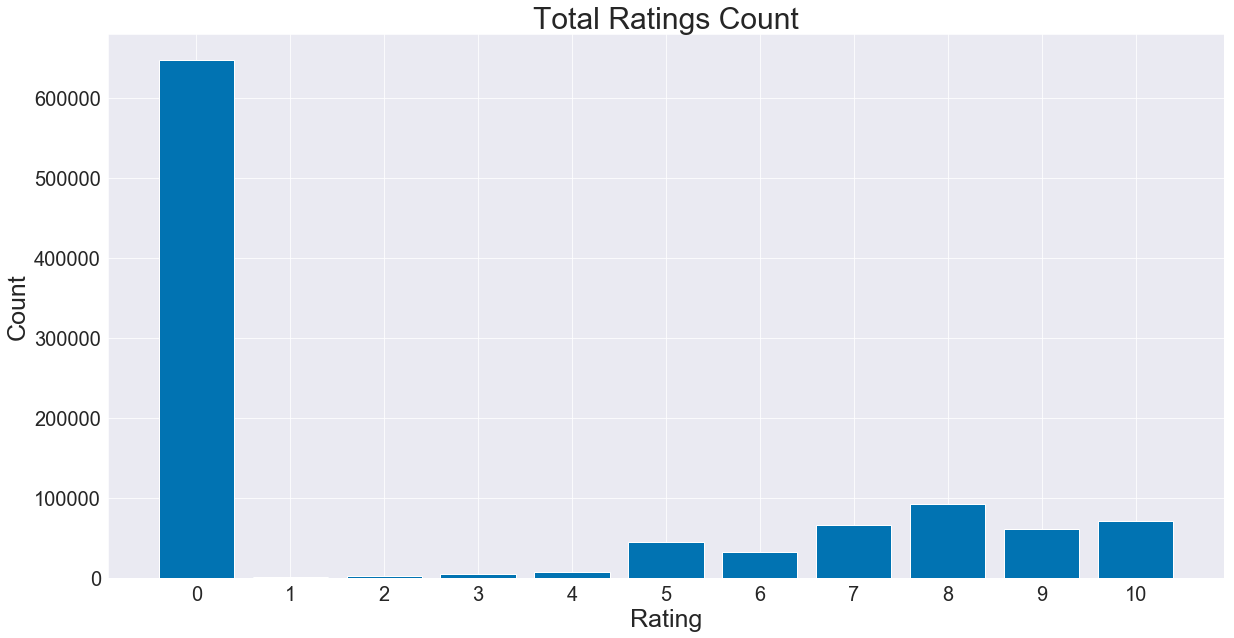

In [38]:
plt.figure(figsize=(20, 10))
plt.bar(x=ratings_and_books['book_rating'].value_counts().index,
        height=ratings_and_books['book_rating'].value_counts().values)
plt.title('Total Ratings Count', fontsize=30)
plt.xlabel('Rating', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.xticks(ratings_df['book_rating'].value_counts().index, fontsize=20)
plt.yticks(fontsize=20);

-  `0` has the greatest book count by far, at 647,323
-  `1` has the least, at 1,481
-  Of the explicit ratings, `8` has the most (91,806)

We'll plot the ratings again, but only include explicit ones to better visualize the count.

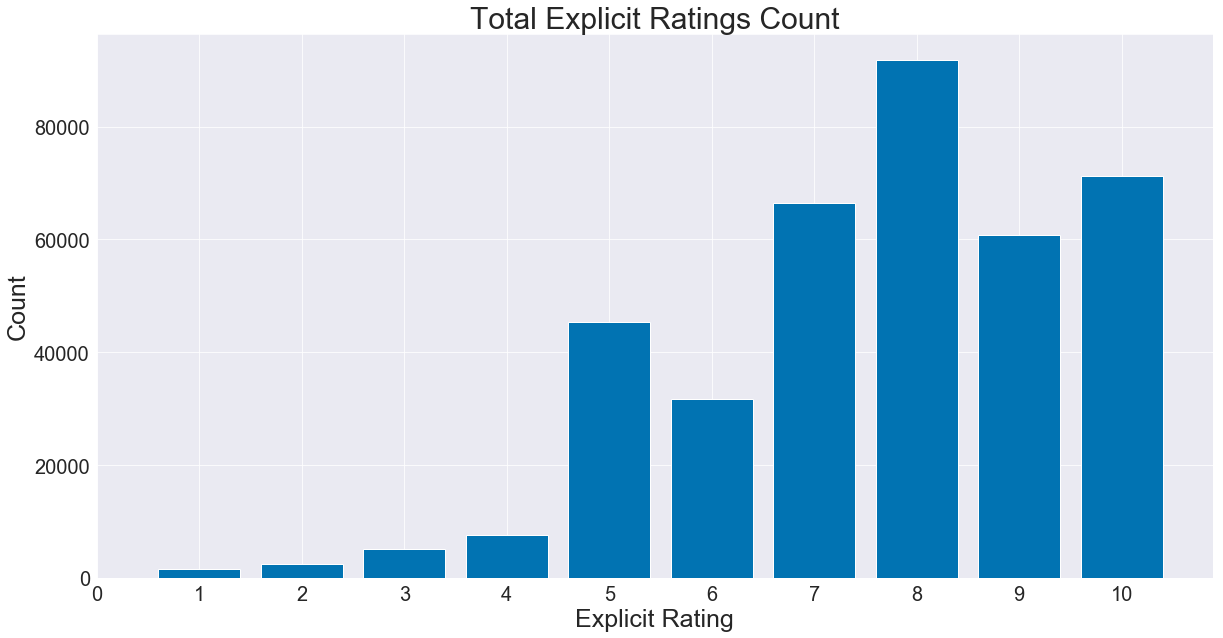

In [39]:
plt.figure(figsize=(20, 10))
plt.bar(x=ratings_and_books['book_rating'].value_counts().index[1:],
        height=ratings_and_books['book_rating'].value_counts().values[1:])
plt.title('Total Explicit Ratings Count', fontsize=30)
plt.xlabel('Explicit Rating', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.xticks(ratings_df['book_rating'].value_counts().index, fontsize=20)
plt.yticks(fontsize=20);

-  With this bar chart, we can clearly see there are books with a rating of `1`, but very few
-  Again, `8` is the most common rating amongst the books
-  Higher ratings (`7-10`) occur more often than lower ratings. This may be because it's more common for readers who have a high preference for a given book to provide a high rating than readers who disliked it.

Now, we'll look at the distribution of ratings given in relation to book count.

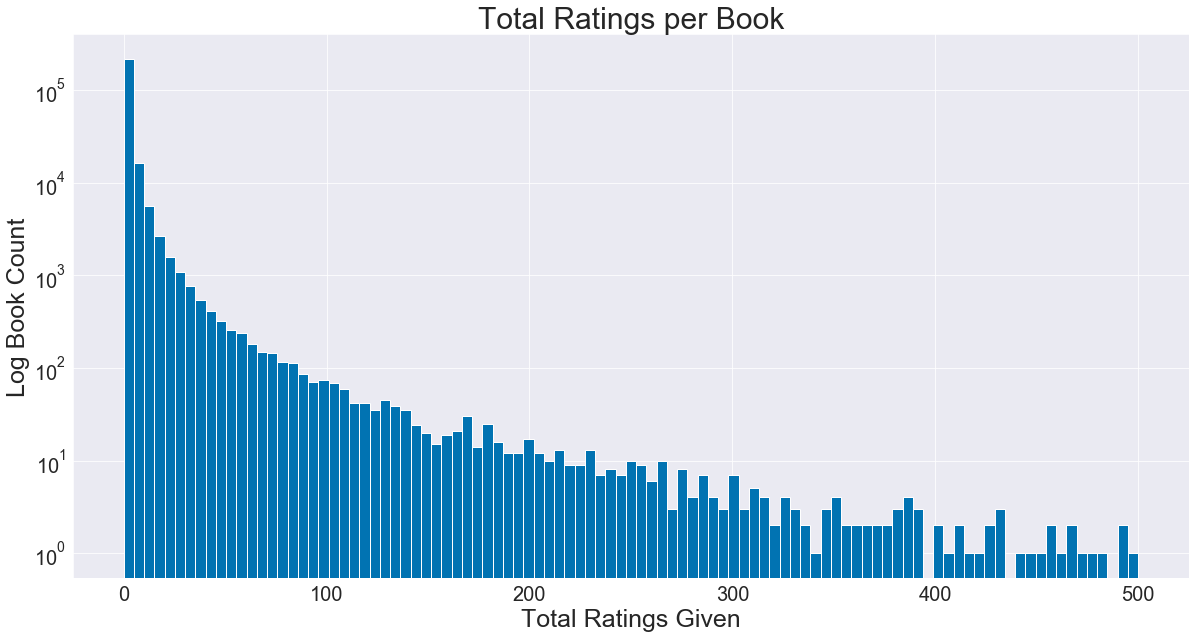

In [40]:
plt.figure(figsize=(20, 10))
plt.hist(x=ratings_and_books['isbn'].value_counts().values,
         bins=np.linspace(0,500,100))
plt.gca().set_yscale("log")
plt.title('Total Ratings per Book', fontsize=30)
plt.xlabel('Total Ratings Given', fontsize=25)
plt.ylabel('Log Book Count', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  Similar to Ratings per User, the histogram is heavily skewed to the right.
-  Most of the books have less than `10` ratings.
-  As we exceed a rating count of `350`, the book count is 1 for the most part. 
-  More than `500` ratings were given for some books, but they were excluded due to its rarity. 

### Save as CSV for PostgreSQL Database

We save out the cleaned `ratings_and_books` dataframe and will put it in the `cleaned_ratings_and_books` table for quick access in the future.

In [41]:
ratings_and_books.to_csv('../data/cleaned_ratings_and_books.csv', index=False)

## Explicit and Implicit Ratings

Given that explicit and implicit ratings provide different insights (preferences vs. interaction), we will separate the two and look further.

In [42]:
exp_ratings = ratings_and_books[ratings_and_books['book_rating'] != 0] 

In [43]:
exp_ratings[['book_rating']].describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,383852.0,7.62671,1.841331,1.0,7.0,8.0,9.0,10.0


The mean for explicit ratings is `7.63`, which aligns with what we saw earlier with the `Total Explicit Ratings Count` bar chart, where `8` had the greatest book count.

In [44]:
imp_ratings = ratings_and_books[ratings_and_books['book_rating'] == 0]

In [45]:
print("Explicit:", exp_ratings.shape[0])
print("Implicit:", imp_ratings.shape[0])

Explicit: 383852
Implicit: 647323


As indicated in the `Total Ratings Count` bar chart before, we have a lot more implicit than explicit ratings. About 60% of the dataset is comprised of implicit ratings, while the remaining 40% is comprised of explicit ratings.

We will create a `ratings_count` dataframe that consists of the implicit rating count, explicit rating count and total rating count. This will allow us to easily see which books are most popular and/or widely read.

In [46]:
imp_count = imp_ratings.groupby(
    ['isbn', 'book_title'], as_index=False)[['book_rating']].count().rename(
    columns={'book_rating': 'implicit_count'})

exp_count = exp_ratings.groupby(
    ['isbn', 'book_title'], as_index=False)[['book_rating']].count().rename(
    columns={'book_rating': 'explicit_count'})

In [47]:
ratings_count = imp_count.merge(exp_count.drop(columns=['book_title']), 
                                how='outer', 
                                on='isbn').fillna(0).astype({'implicit_count': int, 'explicit_count': int})

In [48]:
ratings_count['total_count'] = ratings_count['implicit_count'] + ratings_count['explicit_count']

In [49]:
ratings_count.sort_values(by='total_count', ascending=False).head()

,isbn,book_title,implicit_count,explicit_count,total_count
153681,0971880107,Wild Animus,1921,581,2502
26455,0316666343,The Lovely Bones: A Novel,588,707,1295
52424,0385504209,The Da Vinci Code,399,488,887
22843,0312278586,The Nanny Diaries: A Novel,435,393,828
27220,0330332775,Bridget Jones's Diary,438,377,815


With the `ratings_count` dataframe, we can see the relationship between implicit and explicit ratings.

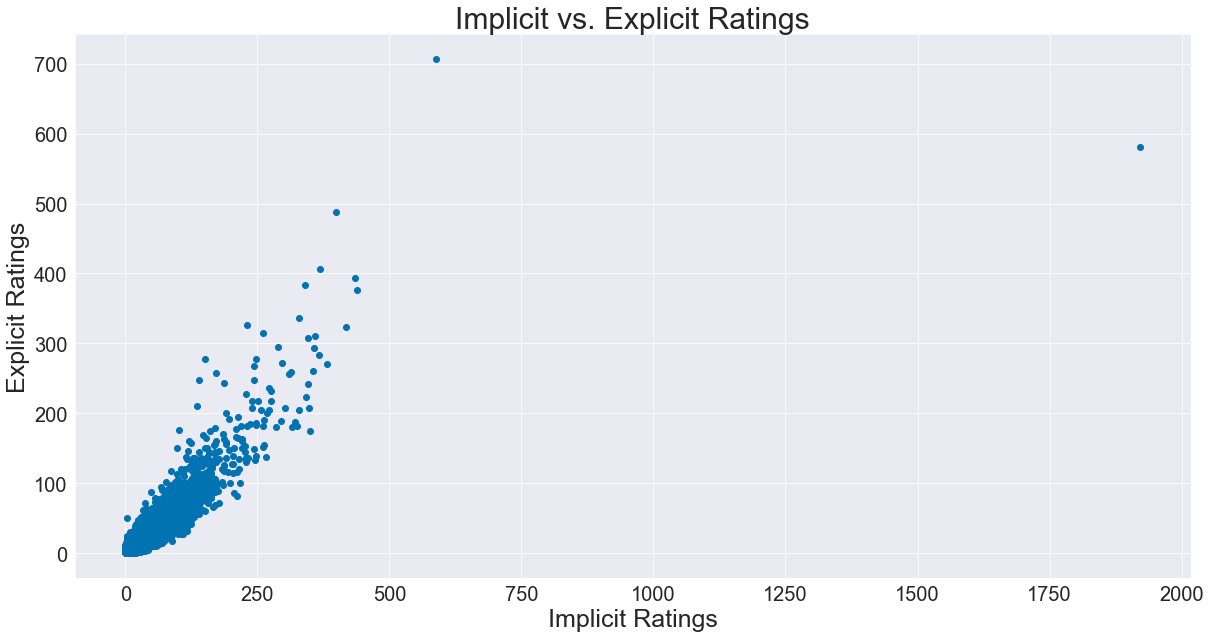

In [50]:
plt.figure(figsize=(20, 10))
plt.scatter(x=ratings_count['implicit_count'],
            y=ratings_count['explicit_count'])
plt.xlabel('Implicit Ratings', fontsize=25)
plt.ylabel('Explicit Ratings', fontsize=25)
plt.title('Implicit vs. Explicit Ratings', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  Positive correlation between implicit and explicit ratings.
-  Similar to what we saw in the distribution of total ratings, most books have a low ratings count.
-  Books appear to have slightly more implicit ratings count than explicit.

We can also see the top 10 most popular books, based on ratings count.

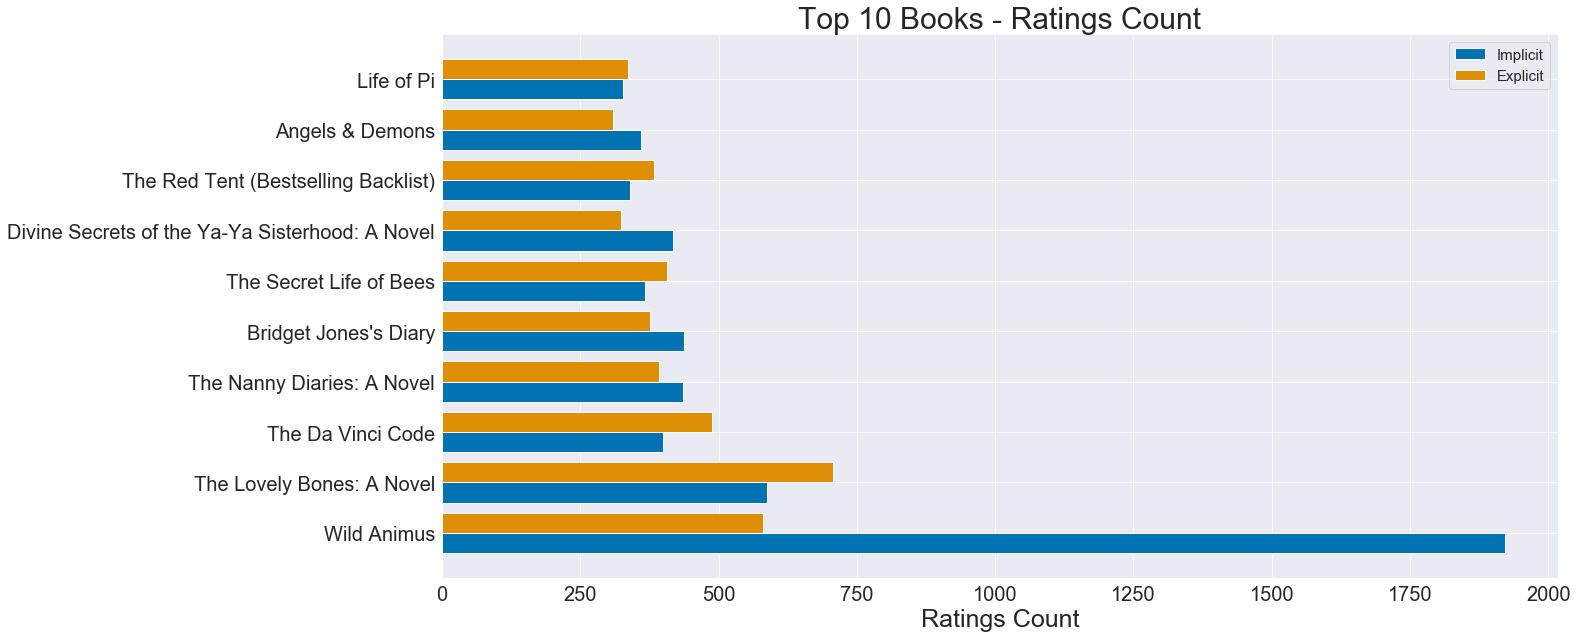

In [51]:
plt.figure(figsize=(20, 10))
plt.barh(y=ratings_count.sort_values(by='total_count', ascending=False)['book_title'].head(10),
         width=ratings_count.sort_values(by='total_count', ascending=False)['implicit_count'].head(10), 
         align='edge',
         height=-.4)
plt.barh(y=ratings_count.sort_values(by='total_count', ascending=False)['book_title'].head(10),
         width=ratings_count.sort_values(by='total_count', ascending=False)['explicit_count'].head(10),
         align='edge',
         height=.4)
plt.legend(['Implicit', 'Explicit'], fontsize=15)
plt.title('Top 10 Books - Ratings Count', fontsize=30)
plt.xlabel('Ratings Count', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  `Wild Animus` have the greatest total count, but most is comprised of implicit ratings.
-  The difference between implicit and explicit ratings count for all other books are relatively similar. 
-  The difference in total ratings count between `Wild Animus` (2502) and `Life of Pi` (664) is significant. This aligns with the `Total Ratings per Book` histogram, where most books had less than 10 ratings.

These books are considered "popular" due to a high interaction rate based on ratings count. We'll add a new column, `avg_rating` to our`ratings_count` dataframe to see the general consensus amongst individuals who interacted with these books. 

In [52]:
avg_rating = exp_ratings.groupby(
    'isbn', as_index=False)[['book_rating']].mean().rename(
    columns={'book_rating': 'rating_avg'})

In [53]:
ratings_count = ratings_count.merge(avg_rating, how='outer', on='isbn').fillna(0)

In [54]:
ratings_count.sort_values(by='total_count', ascending=False).head()

,isbn,book_title,implicit_count,explicit_count,total_count,rating_avg
153681,0971880107,Wild Animus,1921,581,2502,4.390706
26455,0316666343,The Lovely Bones: A Novel,588,707,1295,8.185290
52424,0385504209,The Da Vinci Code,399,488,887,8.438525
22843,0312278586,The Nanny Diaries: A Novel,435,393,828,7.437659
27220,0330332775,Bridget Jones's Diary,438,377,815,7.625995


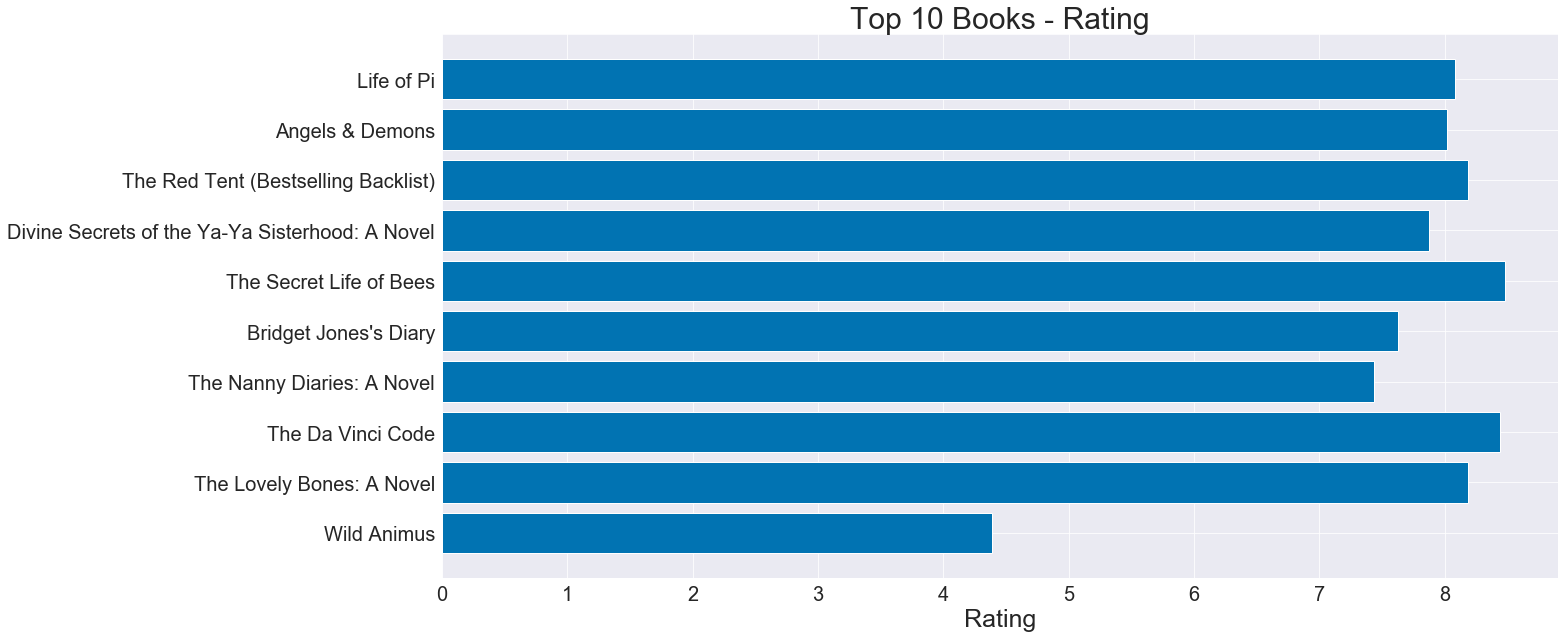

In [55]:
plt.figure(figsize=(20, 10))
plt.barh(y=ratings_count.sort_values(by='total_count', ascending=False)['book_title'].head(10),
         width=ratings_count.sort_values(by='total_count', ascending=False)['rating_avg'].head(10))
plt.title('Top 10 Books - Rating', fontsize=30)
plt.xlabel('Rating', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  Even though `Wild Animus` had the most ratings, it has the lowest average score (`4.4`) among the 10 books.
-  For the most part, the remaining 9 books have an average rating ranging between `7` and `8`. 
-  Given that the overall average rating of our dataset is `7.6`, it's not surprising to see 9 of the 10 books are within this range.

### Save As CSV for PostgreSQL Database

We save out all dataframes to csv and put them in their respective tables on postgres.

In [56]:
exp_ratings.to_csv('../data/exp_ratings.csv', index=False)

In [57]:
imp_ratings.to_csv('../data/imp_ratings.csv', index=False)

In [58]:
ratings_count.to_csv('../data/ratings_count.csv', index=False)